In [13]:
import pandas as pd
import numpy as np
import string
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def load_data(filepath):
    df = pd.read_csv(filepath, encoding='latin-1')
    df = df[['v1', 'v2']]
    df.columns = ['label', 'text']
    return df

# Load your dataset
dataset_path = "spam.csv"  # Change this if needed
df = load_data(dataset_path)
df.head()


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
def preprocess_text(text):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['processed_text'] = df['text'].apply(preprocess_text)
df.head()


,label,text,processed_text
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though


In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['processed_text'])
y = df['label']


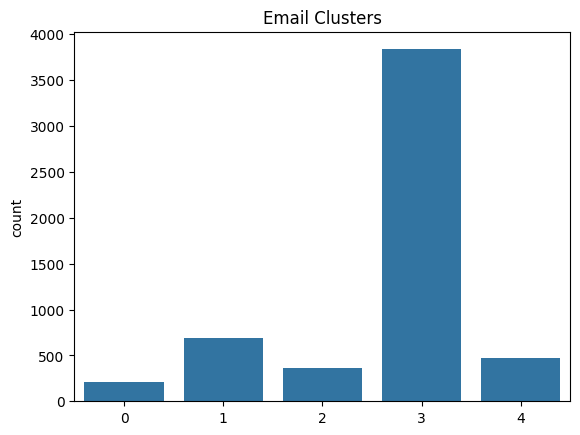

In [ ]:
def cluster_messages(tfidf_matrix, n_clusters=5):
    km = KMeans(n_clusters=n_clusters, random_state=42)
    km.fit(tfidf_matrix)
    return km.labels_

cluster_labels = cluster_messages(X)
sns.countplot(x=cluster_labels)
plt.title("Email Clusters")
plt.show()


In [ ]:
def train_and_evaluate(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Naive Bayes': MultinomialNB()
    }
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"\n{name} Classification Report:\n")
        print(classification_report(y_test, y_pred))
        results[name] = model
    return results

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
models = train_and_evaluate(X_train, X_test, y_train, y_test)



Logistic Regression Classification Report:

              precision    recall  f1-score   support

         ham       0.94      1.00      0.97       965
        spam       0.96      0.61      0.75       150

    accuracy                           0.94      1115
   macro avg       0.95      0.80      0.86      1115
weighted avg       0.95      0.94      0.94      1115


Naive Bayes Classification Report:

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       965
        spam       1.00      0.71      0.83       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



In [14]:
def save_model(model, vectorizer, name):
    joblib.dump(model, f"{name}_model.pkl")
    joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

for name, model in models.items():
    save_model(model, tfidf, name.replace(" ", "_"))


In [ ]:
def alert_if_spam(model, vectorizer, message):
    processed = preprocess_text(message)
    vectorized = vectorizer.transform([processed])
    prediction = model.predict(vectorized)[0]
    if prediction == 'spam':
        print("[ALERT] Spam detected!")
    else:
        print("[INFO] This message appears to be ham (not spam).")
    return prediction

# Loop to allow multiple message inputs
while True:
    user_message = input("Enter an email message (or type 'exit' to quit):\n")
    if user_message.lower() == 'exit':
        print("Exiting spam checker.")
        break
    prediction = alert_if_spam(models['Naive Bayes'], tfidf, user_message)
    print("Prediction:", prediction)
    print("-" * 50)


Enter an email message (or type 'exit' to quit):
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)
[ALERT] Spam detected!
Prediction: spam
--------------------------------------------------
Enter an email message (or type 'exit' to quit):
Flight Itinerary Confirmation
[INFO] This message appears to be ham (not spam).
Prediction: ham
--------------------------------------------------
